# SED Processing of full CIGALE SED Decomposition fits
This script is used to explore and proccess some of the outputs from the fits files generated by the CIGALE SED decomposition. We intend for this to explore the AGN contribution with a more robust set of tools to see how AGN contamination effects UVJ and other diagnostics.

This script extends the previous script with a full breakdown of the entire ZFOURGE catalogue decomposed SEDS so that a full analysis can be conducted.

In [43]:
# Import all required packages
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns

# refresh

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This script is intended to make use of extra fits files provided form ollie to investigate the UVJ diagram.

In particular this is also intended to be used as a stepping stone for the next half of the project.
We will look at quantifying the UVJ points throughout to see how they change with varying parameters.
additionally we may also explore the intermediate type AGN and see how that works.

We will try to find out a way of quantiying the movement with respect to a propgated error and see if we can
make a tool that can be used. 


In [44]:
# Load in all of the filters
# Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')


pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)

In [45]:
# cosmos_decomposed_df
# uds_decomposed_df
# cdfs_decomposed_df

# # Get all SEDs
# def get_all_seds(path):
#     all_seds = []
#     for file in os.listdir(path):

# What i'll need to do for this is to go through my decomposed dataframes and get the SEDs for each galaxy
# I'll also need to cross check this against the full ZFOURGE files and get the redshift for each
# to ensure they are correctly redshifted to the restframe

In [46]:
#Using the full_CDFS_ids.csv, full_UDS_ids.csv and full_COSMOS_ids.csv files, I can get the redshifts for each galaxy
# Read in each file
# Read in full set 
full_cdfs_ids = pd.read_csv('datasets/zfourge/full_CDFS_ids.csv')
full_cosmos_ids = pd.read_csv('datasets/zfourge/full_COSMOS_ids.csv')
full_uds_ids = pd.read_csv('datasets/zfourge/full_UDS_ids.csv')


In [47]:



def get_n_seds(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts



No handles with labels found to put in legend.


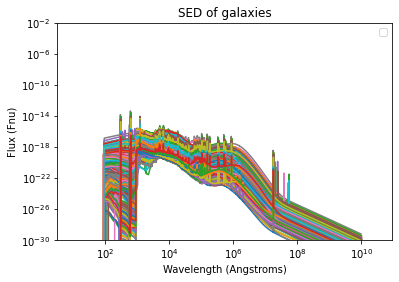

5


In [49]:
# We should be able to use the get_n_seds function to get the SEDs for each galaxy

# cosmos
cosmos_seds, cosmos_names, cosmos_redshifts = get_n_seds(full_cosmos_ids, 5, "COSMOS", restframe=True, all=False)

In [53]:
len(cosmos_names)

5

In [ ]:
#uds
uds_seds, uds_names, uds_redshifts = get_n_seds(full_uds_ids, 5, "UDS",restframe=True, all=True)


In [ ]:
# cdfs
cdfs_seds, cdfs_names, cdfs_redshifts = get_n_seds(full_cdfs_ids, 5, "CDFS",restframe=True, all=True)
